<a href="https://colab.research.google.com/github/yy0750/Unsold_Apartments_Spatial_Analysis/blob/main/Unsold_Apartments_Geo_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Unsold Apartments Geo Analysis

# Module Import

In [231]:
# # 한글
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [232]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from sklearn.preprocessing import StandardScaler
import io
import geopandas as gpd
import seaborn as sns
from branca.colormap import linear

In [233]:
plt.rc('font', family='NanumBarunGothic')

In [234]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Load

In [235]:
df_competition = pd.read_csv('/content/drive/MyDrive/spatio-temporal/경쟁률.csv')
df_unsold = pd.read_csv('/content/drive/MyDrive/spatio-temporal/미분양.csv')
df_population_gdp = pd.read_csv('/content/drive/MyDrive/spatio-temporal/인구수총생산.csv')

In [236]:
df_population_gdp.head(3)

,지역,인구,면적,인구밀도,지역내총생산
0,종로구,150453,23.91,6292,35719537
1,중구,131793,9.96,13232,61342710
2,용산구,227106,21.87,10386,13294640


In [237]:
df_unsold.head(3)

,지역,연도,데이터
0,종로구,2013.1.1,27
1,종로구,2014.1.1,28
2,종로구,2015.1.1,211


In [238]:
df_competition.head(3)

,연도,월,지역,주택 명,공급 세대 수,접수 건수,경쟁률,위도,경도
0,2018,8,노원구,노원 꿈에그린,60,5877,97.95,37.661389,127.061417
1,2018,9,동대문구,장안동 U 포그니 2차,54,547,10.13,37.571126,127.064621
2,2018,10,강서구,신마곡 벽산 블루밍,69,3778,54.75,37.571192,126.804100


# Data Preprocessing

In [239]:
df_unsold['연도'] = df_unsold['연도'].apply(lambda x: str(x).split('.')[0])
df_unsold['순위'] = df_unsold.groupby('연도')['데이터'].rank(method='dense', ascending=False)
df_sorted = df_unsold.sort_values(by=['연도', '순위'])

df_sorted.head()

,지역,연도,데이터,순위
125,마포구,2013,666,1.0
155,구로구,2013,477,2.0
229,강동구,2013,321,3.0
70,성북구,2013,292,4.0
30,성동구,2013,265,5.0


In [240]:
df_competition['연도'] = df_competition['연도'].astype(str)
df_unsold['연도'] = pd.to_datetime(df_unsold['연도']).dt.year.astype(str)
df_competition['merge_key'] = df_competition['연도'] + df_competition['지역']
df_unsold['merge_key'] = df_unsold['연도'] + df_unsold['지역']

merged_data = pd.merge(df_competition, df_unsold, on='merge_key', how='inner', suffixes=('_comp', '_unsold'))
merged_final_data = pd.merge(merged_data, df_population_gdp, left_on='지역_comp', right_on='지역', how='left')

print(merged_final_data.shape)
merged_final_data.head()

(127, 19)


,연도_comp,월,지역_comp,주택 명,공급 세대 수,접수 건수,경쟁률,위도,경도,merge_key,지역_unsold,연도_unsold,데이터,순위,지역,인구,면적,인구밀도,지역내총생산
0,2018,8,노원구,노원 꿈에그린,60,5877,97.95,37.661389,127.061417,2018노원구,노원구,2018,0,7.0,노원구,502925,35.44,14191,6728358
1,2018,9,동대문구,장안동 U 포그니 2차,54,547,10.13,37.571126,127.064621,2018동대문구,동대문구,2018,0,7.0,동대문구,359873,14.22,25315,7711273
2,2018,10,강서구,신마곡 벽산 블루밍,69,3778,54.75,37.571192,126.804100,2018강서구,강서구,2018,0,7.0,강서구,568826,41.45,13723,18347568
3,2018,11,서초구,래미안 리더스원,232,9671,41.69,37.490625,127.024186,2018서초구,서초구,2018,16,1.0,서초구,412078,46.97,8774,38335706
4,2018,12,서초구,디에이치 라클라스,210,5028,23.94,37.500980,127.014169,2018서초구,서초구,2018,16,1.0,서초구,412078,46.97,8774,38335706


# Missing Value Check

In [241]:
merged_final_data.isnull().sum()

연도_comp      0
월            0
지역_comp      0
주택 명         0
공급 세대 수      0
접수 건수        0
경쟁률          0
위도           0
경도           0
merge_key    0
지역_unsold    0
연도_unsold    0
데이터          0
순위           0
지역           0
인구           0
면적           0
인구밀도         0
지역내총생산       0
dtype: int64

# EDA

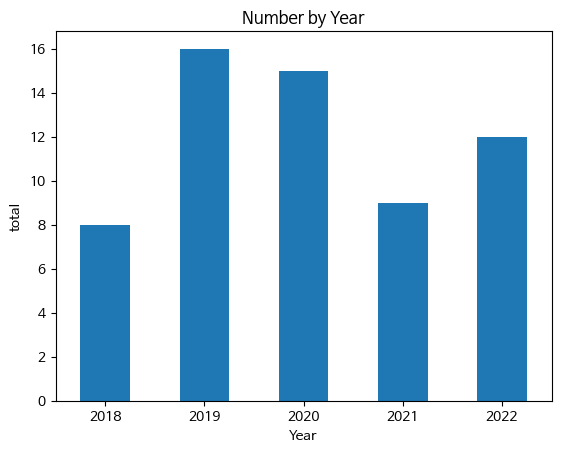

In [242]:
counts = merged_final_data.groupby('연도_comp')['지역_comp'].nunique()

counts.plot(kind='bar', rot=0)
plt.title('Number by Year')
plt.xlabel('Year')
plt.ylabel('total')

plt.show()

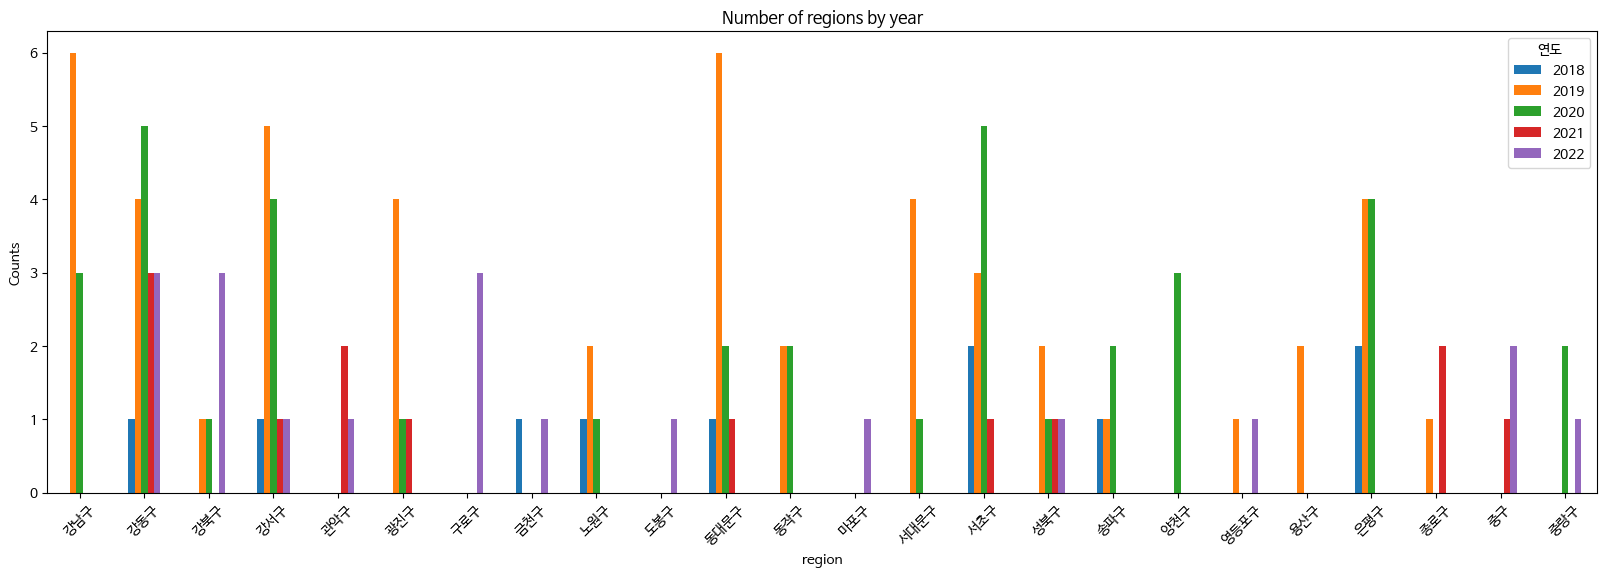

In [243]:
counts = merged_final_data.groupby(['연도_comp', '지역_comp']).size()
counts_df = counts.reset_index(name='Counts')

fig, ax = plt.subplots(figsize=(20, 6))
counts_df.pivot(index='지역_comp', columns='연도_comp', values='Counts').plot(kind='bar', ax=ax)
plt.title('Number of regions by year')
plt.xlabel('region')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.legend(title='연도')
plt.show()

In [244]:
year = '2013'
df_2013 = df_sorted[df_sorted['연도'] == year]

colormap = linear.YlGnBu_09.scale(df_2013['순위'].min(), df_2013['순위'].max())

map_center_latitude = 37.5665
map_center_longitude = 126.9780
map_seoul = folium.Map(location=[map_center_latitude, map_center_longitude], zoom_start=11)

geo_path = '/content/drive/MyDrive/spatio-temporal/hangjeongdong_서울특별시.geojson'

def style_function(feature):
    if feature['properties']['sggnm'] in df_2013['지역'].values:
        rank = df_2013[df_2013['지역'] == feature['properties']['sggnm']]['순위'].values[0]
        return {
            'fillColor': colormap(rank),
            'color': 'black',
            'weight': 0.3,
            'fillOpacity': 0.7
        }
    else:
        return {
            'fillColor': 'white',
            'color': 'black',
            'weight': 0.3,
            'fillOpacity': 0.5
        }

folium.GeoJson(
    geo_path,
    style_function=style_function,
    name='geojson'
).add_to(map_seoul)

colormap.caption = '지역구별 데이터 순위'
colormap.add_to(map_seoul)

map_seoul.save('seoul_map.html')

map_seoul

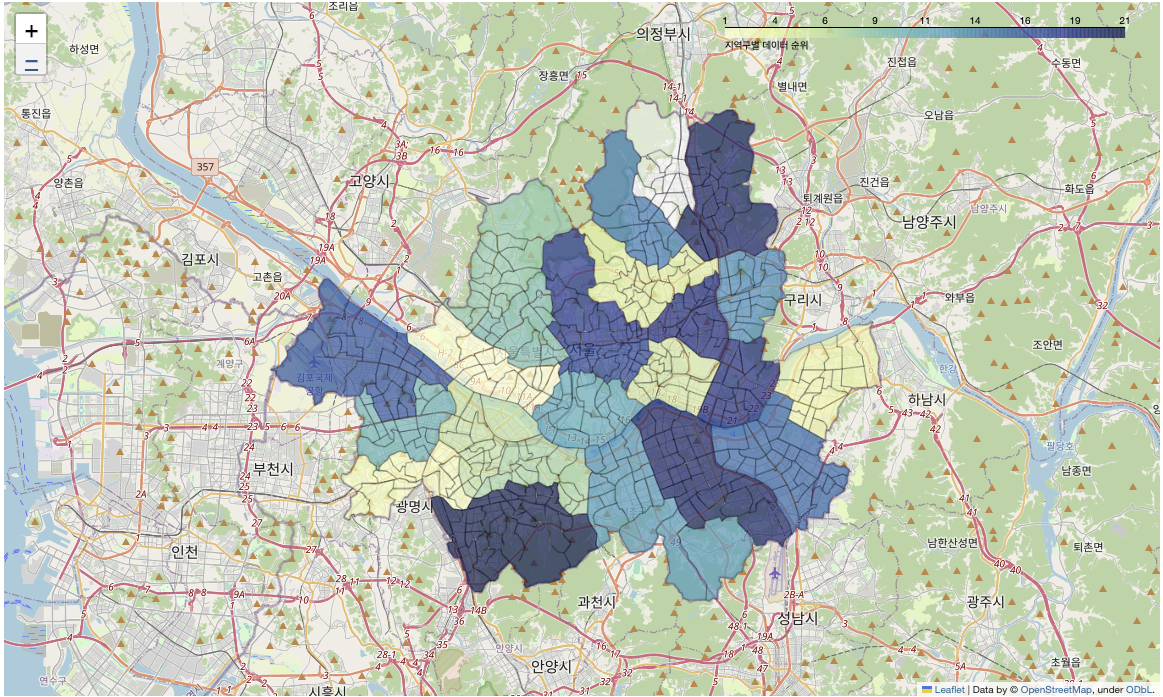

# Correlation Visualize

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


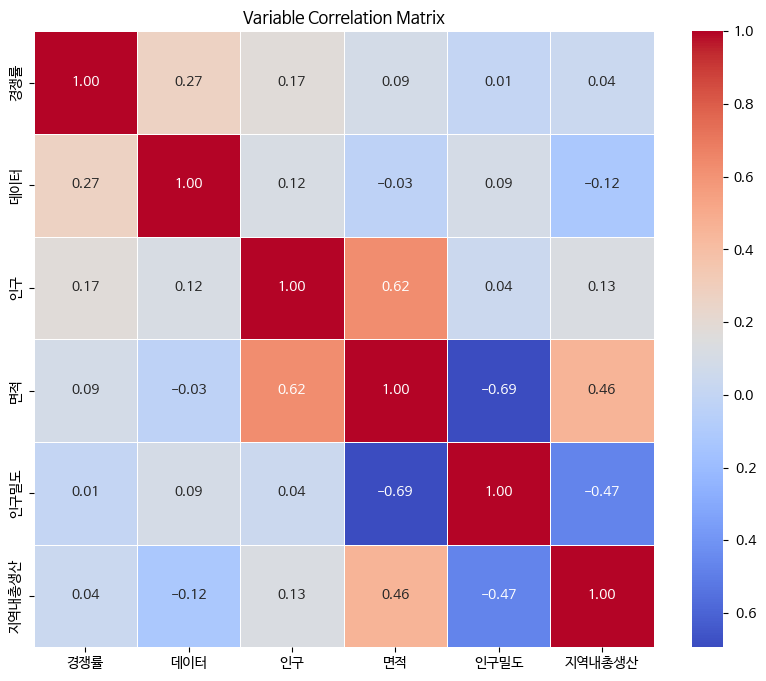

In [245]:
relevant_columns = ['경쟁률', '데이터', '인구', '면적', '인구밀도', '지역내총생산']
correlation_data = merged_final_data[relevant_columns].dropna()
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Variable Correlation Matrix')
plt.show()

# Folium Visualize

In [246]:
map_all_locations = folium.Map(location=[map_center_latitude, map_center_longitude], zoom_start=11)


for idx, row in merged_final_data.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=(f"지역: {row['지역_comp']}")
    ).add_to(map_all_locations)

map_all_locations.save('all_locations.html')

map_all_locations

# Elbow Method

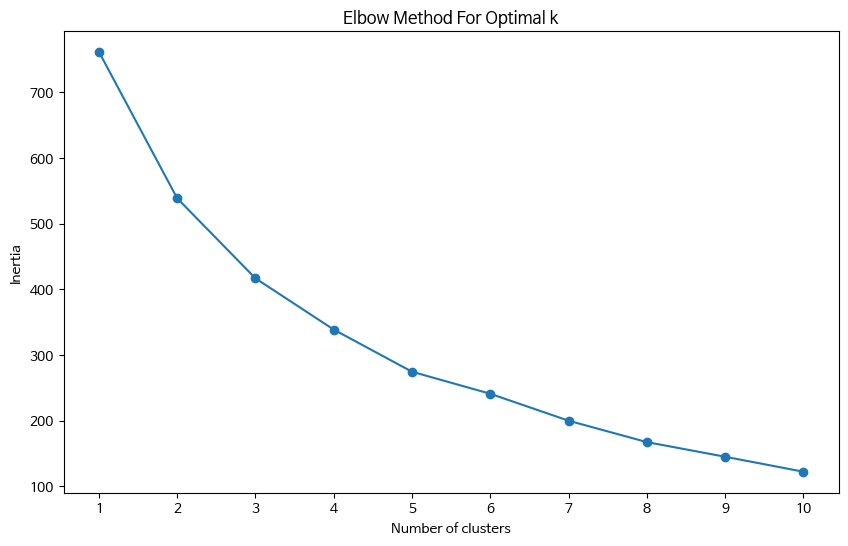

In [247]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(correlation_data)

inertia = []
K_range = range(1, 11)
for k in K_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(scaled_data)
    inertia.append(model.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.show()

# Kmeans Clustering

In [248]:
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_data)

merged_final_data['Cluster'] = clusters

map_seoul = folium.Map(location=[map_center_latitude, map_center_longitude], zoom_start=11)

cluster_colors = ['blue', 'green', 'red', 'purple']

for idx, row in merged_final_data.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=5,
        color=cluster_colors[row['Cluster']],
        fill=True,
        fill_color=cluster_colors[row['Cluster']],
        fill_opacity=0.7,
        popup=(f"지역: {row['지역_comp']}, 경쟁률: {row['경쟁률']}")
    ).add_to(map_seoul)

map_seoul.save('seoul_unsold_apartments.html')

map_seoul